# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import Dense
from keras.layers import LSTM,Input
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [2]:
# Read the data
data=pd.read_csv("generated_data.csv")

In [3]:
data

,timestamp,temperature,pressure,humidity,temperature_status,pressure_status,humidity_status
0,2023-01-01 00:00:00,28.10,105.27,32.26,normal,normal,anomalous
1,2023-01-01 00:05:00,22.53,102.69,71.83,anomalous,normal,anomalous
2,2023-01-01 00:10:00,34.63,100.23,65.88,normal,normal,normal
3,2023-01-01 00:15:00,25.32,81.32,74.68,normal,anomalous,anomalous
4,2023-01-01 00:20:00,28.75,97.69,42.93,normal,normal,normal
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,39.72,109.03,57.36,anomalous,normal,normal
996,2023-01-04 11:00:00,38.78,103.67,77.07,anomalous,normal,anomalous
997,2023-01-04 11:05:00,35.97,111.50,72.28,anomalous,anomalous,anomalous
998,2023-01-04 11:10:00,24.67,95.94,68.69,anomalous,normal,normal


# Temperature sensor

#### Convert the temperature status from catorigical to numerical

In [4]:
# Select the timestamp,temperature column and the temperature_status column from the data
data_temp = data.loc[:, ['timestamp', 'temperature',"temperature_status"]]
data_temp 

,timestamp,temperature,temperature_status
0,2023-01-01 00:00:00,28.10,normal
1,2023-01-01 00:05:00,22.53,anomalous
2,2023-01-01 00:10:00,34.63,normal
3,2023-01-01 00:15:00,25.32,normal
4,2023-01-01 00:20:00,28.75,normal
...,...,...,...
995,2023-01-04 10:55:00,39.72,anomalous
996,2023-01-04 11:00:00,38.78,anomalous
997,2023-01-04 11:05:00,35.97,anomalous
998,2023-01-04 11:10:00,24.67,anomalous


In [5]:
# Convert the temperature_status column to binary values
data_temp.loc[data_temp["temperature_status"]=="normal","temperature_status"]=0
data_temp.loc[data_temp["temperature_status"]=="anomalous","temperature_status"]=1
data_temp

,timestamp,temperature,temperature_status
0,2023-01-01 00:00:00,28.10,0
1,2023-01-01 00:05:00,22.53,1
2,2023-01-01 00:10:00,34.63,0
3,2023-01-01 00:15:00,25.32,0
4,2023-01-01 00:20:00,28.75,0
...,...,...,...
995,2023-01-04 10:55:00,39.72,1
996,2023-01-04 11:00:00,38.78,1
997,2023-01-04 11:05:00,35.97,1
998,2023-01-04 11:10:00,24.67,1


In [6]:
def standraization(df, column_name):
    # Calculate Z-scores
    z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
    df["temperature_standar"]=z_scores
    return df

In [7]:
data_temp["temperature"].min(), data_temp["temperature"].max()

(20.02, 39.98)

##### Analysing the data readout and plot a sample

In [8]:
# The number of normal and anomalous temperature values
data_temp.loc[data_temp["temperature_status"]==0]["timestamp"].count(), data_temp.loc[data_temp["temperature_status"]==1]["timestamp"].count()

(508, 492)

In [9]:
# The range of timestamps
data_temp["timestamp"].min(), data_temp["timestamp"].max()

('2023-01-01 00:00:00', '2023-01-04 11:15:00')

In [10]:
# The number of temperature values recorded on the first two days
first_2days= data_temp.loc[data_temp["timestamp"]<'2023-01-03']
first_2days

,timestamp,temperature,temperature_status
0,2023-01-01 00:00:00,28.10,0
1,2023-01-01 00:05:00,22.53,1
2,2023-01-01 00:10:00,34.63,0
3,2023-01-01 00:15:00,25.32,0
4,2023-01-01 00:20:00,28.75,0
...,...,...,...
571,2023-01-02 23:35:00,33.79,0
572,2023-01-02 23:40:00,33.82,0
573,2023-01-02 23:45:00,38.10,1
574,2023-01-02 23:50:00,36.80,1


In [11]:
# The number of normal and anomalous temperature values recorded on the first two days
first_2days.loc[first_2days["temperature_status"]==0]["timestamp"].count(), first_2days.loc[first_2days["temperature_status"]==1]["timestamp"].count()

(297, 279)

In [12]:
therd_day= data_temp.loc[(data_temp["timestamp"]>'2023-01-03') & (data_temp["timestamp"]<'2023-01-04')]

In [13]:
therd_day

,timestamp,temperature,temperature_status
576,2023-01-03 00:00:00,31.02,0
577,2023-01-03 00:05:00,26.88,0
578,2023-01-03 00:10:00,23.28,1
579,2023-01-03 00:15:00,23.87,1
580,2023-01-03 00:20:00,28.87,0
...,...,...,...
859,2023-01-03 23:35:00,34.65,0
860,2023-01-03 23:40:00,32.64,0
861,2023-01-03 23:45:00,29.05,0
862,2023-01-03 23:50:00,34.41,0


In [14]:
# The number of normal and anomalous temperature values recorded on the therd day
therd_day.loc[therd_day["temperature_status"]==0]["timestamp"].count(), therd_day.loc[therd_day["temperature_status"]==1]["timestamp"].count()

(147, 141)

In [15]:
# The number of temperature values recorded on the last day
last_day= data_temp.loc[data_temp["timestamp"]>='2023-01-04']
last_day

,timestamp,temperature,temperature_status
864,2023-01-04 00:00:00,25.53,0
865,2023-01-04 00:05:00,35.28,1
866,2023-01-04 00:10:00,39.47,1
867,2023-01-04 00:15:00,20.80,1
868,2023-01-04 00:20:00,34.56,0
...,...,...,...
995,2023-01-04 10:55:00,39.72,1
996,2023-01-04 11:00:00,38.78,1
997,2023-01-04 11:05:00,35.97,1
998,2023-01-04 11:10:00,24.67,1


In [16]:
# The number of normal and anomalous temperature values recorded on the last two days
last_day.loc[last_day["temperature_status"]==0]["timestamp"].count(), last_day.loc[last_day["temperature_status"]==1]["timestamp"].count()

(64, 72)

In [17]:
# Standarize the temperature values
first_2days=standraization(first_2days, "temperature")
therd_day=standraization(therd_day, "temperature")
last_day=standraization(last_day, "temperature")

C:\Users\adnan\AppData\Local\Temp\ipykernel_14400\2181701519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperature_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_14400\2181701519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperature_standar"]=z_scores
C:\Users\adnan\AppData\Local\Temp\ipykernel_14400\2181701519.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [18]:
# first 7 rows
data_temp.head(7)

,timestamp,temperature,temperature_status
0,2023-01-01 00:00:00,28.10,0
1,2023-01-01 00:05:00,22.53,1
2,2023-01-01 00:10:00,34.63,0
3,2023-01-01 00:15:00,25.32,0
4,2023-01-01 00:20:00,28.75,0
5,2023-01-01 00:25:00,22.56,1
6,2023-01-01 00:30:00,29.44,0


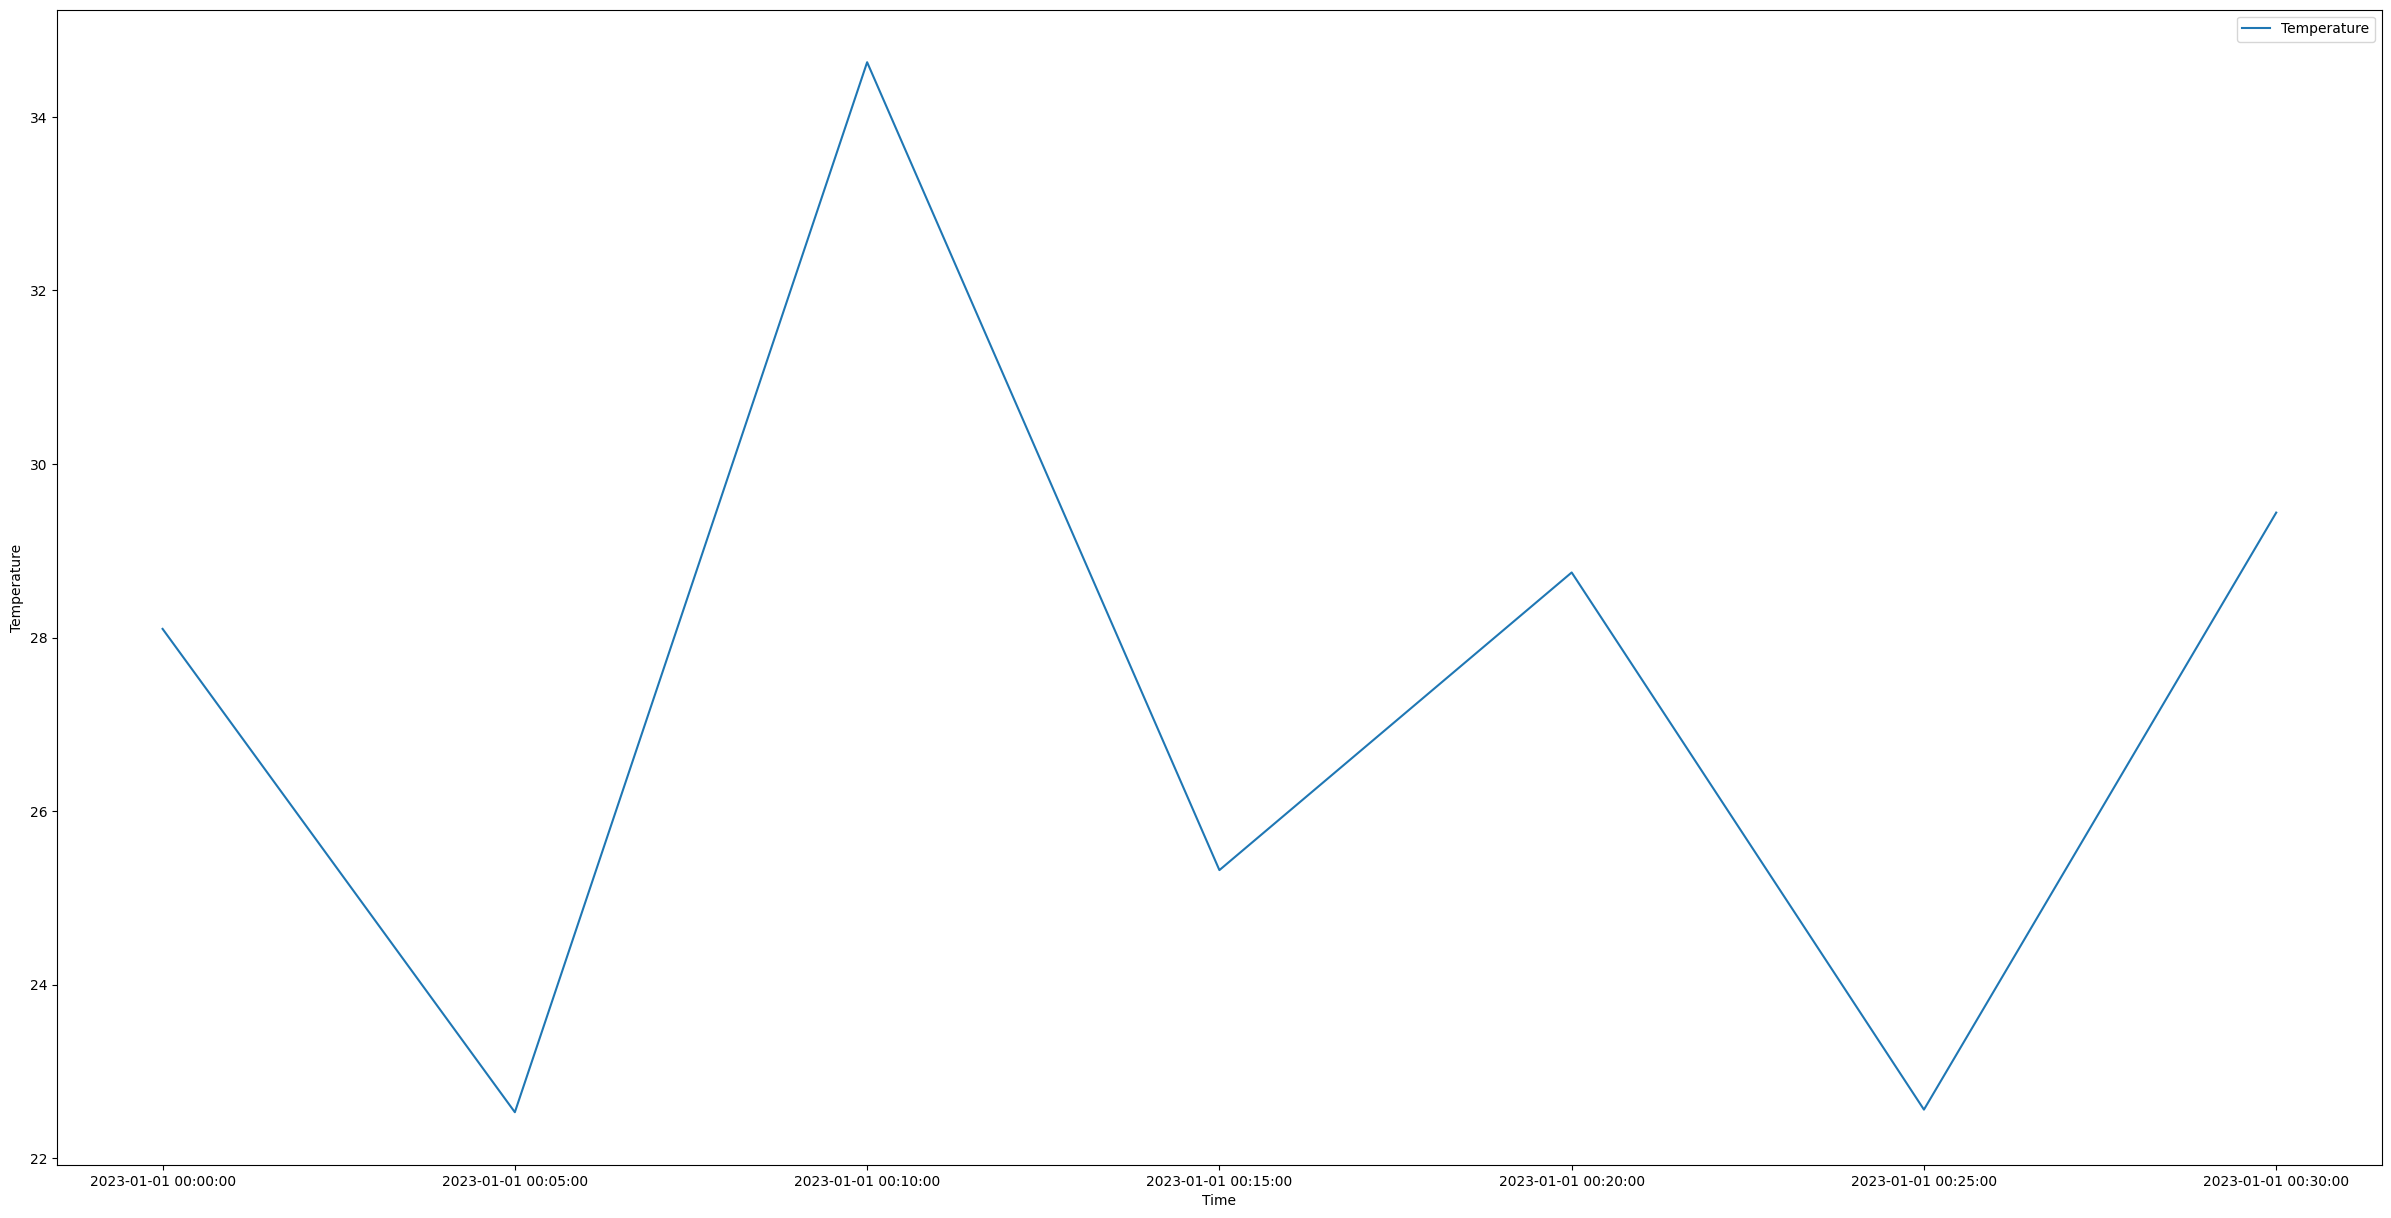

In [19]:
# Plot the first 7 temperature values
plt.figure(figsize=(30,15))
plt.plot(data_temp["timestamp"].head(7), data_temp["temperature"].head(7), label="Temperature")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.legend()
plt.show()

- The data is balanced there are almost same number of reads out for each class.
- We can see the stand temperature can indicate a strong variasion between the previos temperatuer and the current one whcih help the model to idenife if there are some anomalous values.
- Window size of 1 readout which indicate a 5 minute.
- Split the data into test and train, the data are collected in 4 days, so train 2 days,valdation 1 day and test 1 day.

##### Spliting the data

In [20]:
train = first_2days
valdation= therd_day
test = last_day

In [21]:
train

,timestamp,temperature,temperature_status,temperature_standar
0,2023-01-01 00:00:00,28.10,0,0.365068
1,2023-01-01 00:05:00,22.53,1,1.329595
2,2023-01-01 00:10:00,34.63,0,0.765697
3,2023-01-01 00:15:00,25.32,0,0.846466
4,2023-01-01 00:20:00,28.75,0,0.252511
...,...,...,...,...
571,2023-01-02 23:35:00,33.79,0,0.620239
572,2023-01-02 23:40:00,33.82,0,0.625434
573,2023-01-02 23:45:00,38.10,1,1.366579
574,2023-01-02 23:50:00,36.80,1,1.141465


##### Preparing the data in sequences (number of samples, window size, number of features)

In [22]:
def sequence(data, timesteps, num_features):
    num_samples = len(data) - timesteps + 1  
    df = np.zeros((num_samples, timesteps, num_features))
    for i in range(num_samples):
        df[i] = data[i:i+timesteps, :] 

    return df

In [23]:
def prepare_y(train, timesteps):
    num_samples = len(train) - timesteps + 1
    y_train = np.zeros((num_samples, 1))
    for i in range(num_samples):
        y_train[i] = train["temperature_status"].values[i + timesteps - 1]

    return y_train

In [24]:
data_n= train.loc[train["temperature_status"]==0]
data_d = data_n.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_train = sequence(data_d, 1, 1)
x_train.shape

(297, 1, 1)

In [25]:
data_n= valdation.loc[valdation["temperature_status"]==0]
data_d = data_n.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_valdation = sequence(data_d, 1, 1)
x_valdation.shape

(147, 1, 1)

In [26]:
data_t = test.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_test = sequence(data_t, 1, 1)
x_test.shape

(136, 1, 1)

#### Autoencoder LSTM model

In [27]:

timesteps = x_train.shape[1]
n_features = x_train.shape[2]

lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(Input(shape=(timesteps, n_features)))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder.add(LSTM(512, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(256, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(128, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(64, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation="relu", return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation="relu", return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 16)          │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 128)         │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 1, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 1, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 1, 16)          │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 1)           │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,248,977 (20.02 MB)

 Trainable params: 5,248,977 (20.02 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [29]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(x_train,x_train, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation, x_valdation),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400


10/10 - 7s - 731ms/step - loss: 0.2635 - val_loss: 0.2736
Epoch 2/400
10/10 - 0s - 16ms/step - loss: 0.2619 - val_loss: 0.2719
Epoch 3/400
10/10 - 0s - 16ms/step - loss: 0.2602 - val_loss: 0.2702
Epoch 4/400
10/10 - 0s - 16ms/step - loss: 0.2585 - val_loss: 0.2685
Epoch 5/400
10/10 - 0s - 16ms/step - loss: 0.2568 - val_loss: 0.2667
Epoch 6/400
10/10 - 0s - 17ms/step - loss: 0.2550 - val_loss: 0.2648
Epoch 7/400
10/10 - 0s - 16ms/step - loss: 0.2531 - val_loss: 0.2629
Epoch 8/400
10/10 - 0s - 16ms/step - loss: 0.2512 - val_loss: 0.2610
Epoch 9/400
10/10 - 0s - 19ms/step - loss: 0.2493 - val_loss: 0.2590
Epoch 10/400
10/10 - 0s - 17ms/step - loss: 0.2473 - val_loss: 0.2570
Epoch 11/400
10/10 - 0s - 17ms/step - loss: 0.2454 - val_loss: 0.2550
Epoch 12/400
10/10 - 0s - 16ms/step - loss: 0.2434 - val_loss: 0.2530
Epoch 13/400
10/10 - 0s - 16ms/step - loss: 0.2413 - val_loss: 0.2509
Epoch 14/400
10/10 - 0s - 18ms/step - loss: 0.2392 - val_loss: 0.2488
Epoch 15/400
10/10 - 0s - 17ms/step - lo

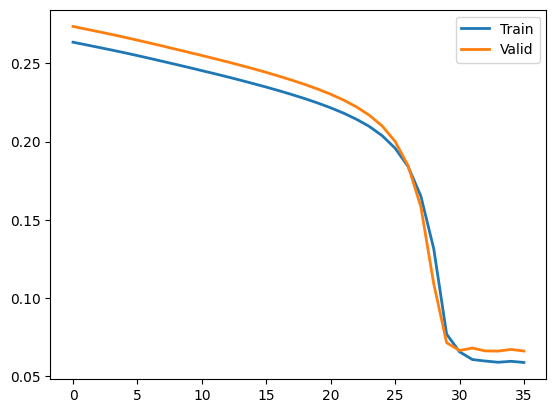

In [30]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step
Reconstruction error threshold: 0.4504168570050672


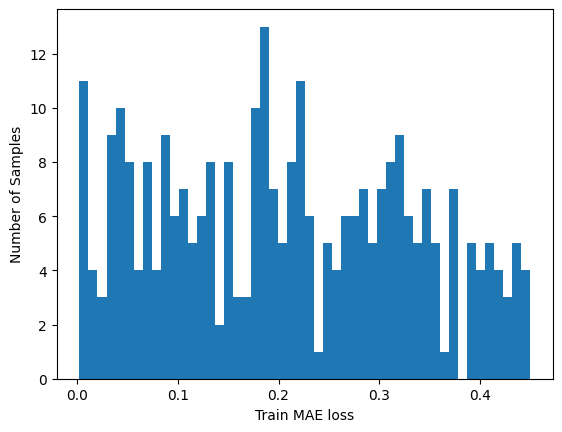

In [31]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0, 0.5, 'Number of samples')

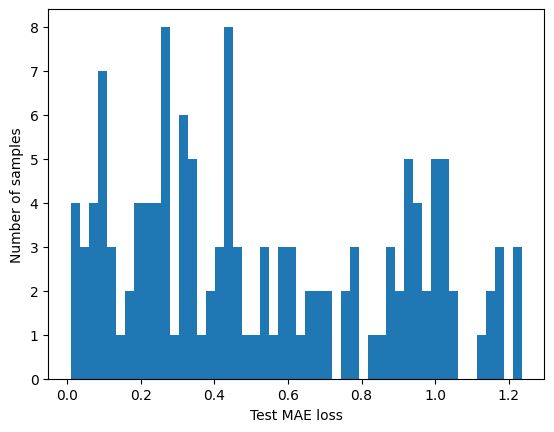

In [32]:
X_test_pred = lstm_autoencoder.predict(x_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [33]:
anomaly_df = test.copy()
anomaly_df.loc[:, 'loss'] = test_mae_loss
anomaly_df.loc[:, 'threshold'] = threshold
anomaly_df.loc[:, 'anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']
anomaly_df

,timestamp,temperature,temperature_status,temperature_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,25.53,0,0.778164,0.327261,0.450417,False
865,2023-01-04 00:05:00,35.28,1,0.879792,0.428865,0.450417,False
866,2023-01-04 00:10:00,39.47,1,1.592288,1.141182,0.450417,True
867,2023-01-04 00:15:00,20.80,1,1.582485,1.131381,0.450417,True
868,2023-01-04 00:20:00,34.56,0,0.757358,0.306460,0.450417,False
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,39.72,1,1.634800,1.183682,0.450417,True
996,2023-01-04 11:00:00,38.78,1,1.474956,1.023880,0.450417,True
997,2023-01-04 11:05:00,35.97,1,0.997124,0.546169,0.450417,True
998,2023-01-04 11:10:00,24.67,1,0.924404,0.473466,0.450417,True


In [34]:
anomaly_df.loc[anomaly_df['anomaly']==False]=0
anomaly_df.loc[anomaly_df['anomaly']==True]=1
anomaly_df

C:\Users\adnan\AppData\Local\Temp\ipykernel_14400\1612888637.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  anomaly_df.loc[anomaly_df['anomaly']==False]=0


,timestamp,temperature,temperature_status,temperature_standar,loss,threshold,anomaly
864,0,0.0,0,0.0,0.0,0.0,0
865,0,0.0,0,0.0,0.0,0.0,0
866,1,1.0,1,1.0,1.0,1.0,1
867,1,1.0,1,1.0,1.0,1.0,1
868,0,0.0,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
995,1,1.0,1,1.0,1.0,1.0,1
996,1,1.0,1,1.0,1.0,1.0,1
997,1,1.0,1,1.0,1.0,1.0,1
998,1,1.0,1,1.0,1.0,1.0,1


In [35]:
anomaly_df_temp_status=anomaly_df["temperature_status"].astype(int)
anomaly_df_predicted=anomaly_df["anomaly"].astype(int)

In [36]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        70
           1       1.00      1.00      1.00        66

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136

[[70  0]
 [ 0 66]]


# __________________________________________________________________________________________

In [37]:
data_d = train.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_train_both = sequence(data_d, 1, 1)
x_train_both.shape

(576, 1, 1)

In [38]:
data_d = valdation.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_valdation_both = sequence(data_d, 1, 1)
x_valdation_both.shape

(288, 1, 1)

In [39]:
data_t = test.drop(['temperature',"temperature_status","timestamp"], axis=1).values
x_test_both = sequence(data_t, 1, 1)
x_test_both.shape

(136, 1, 1)

In [40]:
timesteps = x_train_both.shape[1]
n_features = x_train_both.shape[2]

lstm_autoencoder_both = Sequential()
# Encoder
lstm_autoencoder_both.add(Input(shape=(timesteps, n_features)))

lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=False))

# Adding RepeatVector to match the input sequence length for decoding
lstm_autoencoder_both.add(RepeatVector(timesteps))

# Decoder
lstm_autoencoder_both.add(LSTM(512, activation="sigmoid", return_sequences=True))

lstm_autoencoder_both.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder_both.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 512)            │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 1, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 1, 512)         │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 1, 1)           │           513 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,152,385 (12.03 MB)

 Trainable params: 3,152,385 (12.03 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Define the Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2,mode="min", verbose=1, restore_best_weights=True)

In [42]:
epochs = 400
batch = 32
lr = 0.0001
adam = optimizers.Adam(lr)
lstm_autoencoder_both.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.keras",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history_both = lstm_autoencoder_both.fit(x_train_both,x_train_both, 
                                                epochs=epochs, 
                                                batch_size=batch,
                                                validation_data=(x_valdation_both, x_valdation_both),
                                                callbacks=early_stopping,
                                                verbose=2).history


Epoch 1/400
18/18 - 1s - 72ms/step - loss: 0.9261 - val_loss: 0.2491
Epoch 2/400
18/18 - 0s - 9ms/step - loss: 0.2726 - val_loss: 0.2731
Epoch 3/400
18/18 - 0s - 8ms/step - loss: 0.2591 - val_loss: 0.2415
Epoch 4/400
18/18 - 0s - 9ms/step - loss: 0.2431 - val_loss: 0.2384
Epoch 5/400
18/18 - 0s - 9ms/step - loss: 0.2416 - val_loss: 0.2378
Epoch 6/400
18/18 - 0s - 9ms/step - loss: 0.2409 - val_loss: 0.2374
Epoch 7/400
18/18 - 0s - 9ms/step - loss: 0.2409 - val_loss: 0.2367
Epoch 8/400
18/18 - 0s - 8ms/step - loss: 0.2397 - val_loss: 0.2361
Epoch 9/400
18/18 - 0s - 8ms/step - loss: 0.2412 - val_loss: 0.2365
Epoch 10/400
18/18 - 0s - 8ms/step - loss: 0.2391 - val_loss: 0.2348
Epoch 11/400
18/18 - 0s - 8ms/step - loss: 0.2381 - val_loss: 0.2347
Epoch 12/400
18/18 - 0s - 8ms/step - loss: 0.2372 - val_loss: 0.2340
Epoch 13/400
18/18 - 0s - 9ms/step - loss: 0.2366 - val_loss: 0.2328
Epoch 14/400
18/18 - 0s - 8ms/step - loss: 0.2360 - val_loss: 0.2322
Epoch 15/400
18/18 - 0s - 8ms/step - loss:

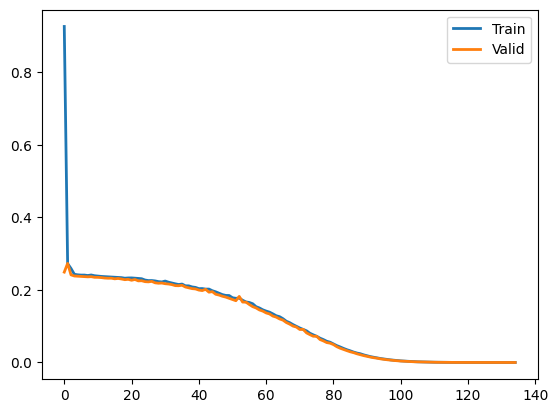

In [43]:
plt.plot(lstm_autoencoder_history_both['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history_both['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Text(0, 0.5, 'Number of Samples')

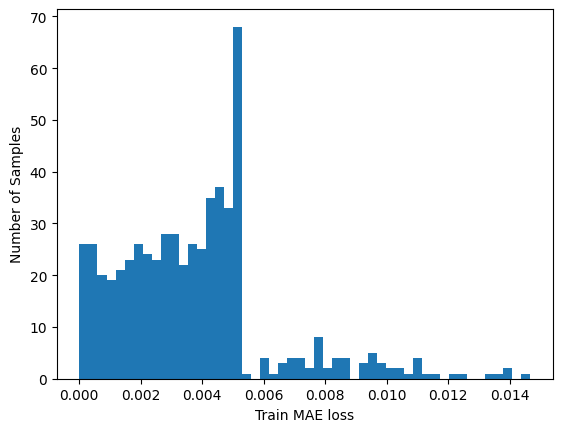

In [44]:
# Mean Absolute Error loss
x_train_pred = lstm_autoencoder_both.predict(x_train_both)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train_both), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

In [72]:
threshold = 0.005

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Number of samples')

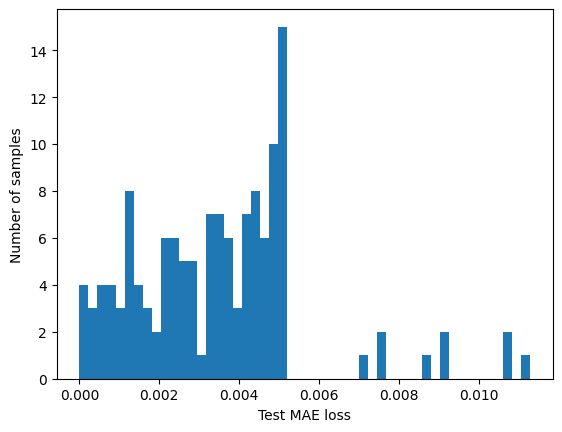

In [73]:
X_test_pred = lstm_autoencoder_both.predict(x_test_both, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-x_test_both), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [74]:
anomaly_df_both = test.copy()
anomaly_df_both.loc[:, 'loss'] = test_mae_loss
anomaly_df_both.loc[:, 'threshold'] = threshold
anomaly_df_both.loc[:, 'anomaly'] = anomaly_df_both['loss'] > anomaly_df_both['threshold']
anomaly_df_both

,timestamp,temperature,temperature_status,temperature_standar,loss,threshold,anomaly
864,2023-01-04 00:00:00,25.53,0,0.778164,0.005029,0.005,True
865,2023-01-04 00:05:00,35.28,1,0.879792,0.005133,0.005,True
866,2023-01-04 00:10:00,39.47,1,1.592288,0.007474,0.005,True
867,2023-01-04 00:15:00,20.80,1,1.582485,0.007109,0.005,True
868,2023-01-04 00:20:00,34.56,0,0.757358,0.004963,0.005,False
...,...,...,...,...,...,...,...
995,2023-01-04 10:55:00,39.72,1,1.634800,0.009133,0.005,True
996,2023-01-04 11:00:00,38.78,1,1.474956,0.003493,0.005,False
997,2023-01-04 11:05:00,35.97,1,0.997124,0.004759,0.005,False
998,2023-01-04 11:10:00,24.67,1,0.924404,0.005057,0.005,True


In [75]:
anomaly_df_both.loc[anomaly_df_both['anomaly']==True].count()

timestamp              24
temperature            24
temperature_status     24
temperature_standar    24
loss                   24
threshold              24
anomaly                24
dtype: int64

In [76]:
anomaly_df_both.loc[anomaly_df_both['anomaly']==False].count()

timestamp              112
temperature            112
temperature_status     112
temperature_standar    112
loss                   112
threshold              112
anomaly                112
dtype: int64

In [77]:
anomaly_df_temp_status=anomaly_df_both["temperature_status"].astype(int)
anomaly_df_predicted=anomaly_df_both["anomaly"].astype(int)

In [78]:
report=classification_report(anomaly_df_temp_status, anomaly_df_predicted)
print(report)
conf=confusion_matrix(anomaly_df_temp_status, anomaly_df_predicted)
print(conf)

              precision    recall  f1-score   support

           0       0.53      0.92      0.67        64
           1       0.79      0.26      0.40        72

    accuracy                           0.57       136
   macro avg       0.66      0.59      0.53       136
weighted avg       0.67      0.57      0.53       136

[[59  5]
 [53 19]]
